Alejandra Velasco Zárate A01635453

José Antonio Juárez Pacheco A0057218

José Carlos Yamuni Contreras A01740285

Juan Manuel Hernández Solano A00572208

In [1]:
# Importar librerías

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
import os
from skimage import io, feature
from skimage.transform import resize
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray, rgb2lab
from skimage import img_as_ubyte
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.datasets import fashion_mnist
import keras_tuner
from matplotlib.colors import ListedColormap
from minisom import MiniSom   

C:\Users\Alejandra Velasco\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Agrupamientos de imágenes Fashion-MNIST

In [2]:
# Cargar el conjunto de datos Fashion MNIST completo
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

# Combinar todas las imágenes y etiquetas en un solo conjunto
all_images = train_images
all_labels = train_labels

# Normalización de imágenes
all_images = all_images.reshape((all_images.shape[0], -1)) / 255.0

# Verificar las dimensiones del conjunto de datos
print("Dimensiones del conjunto de imágenes:", all_images.shape)
print("Dimensiones del conjunto de etiquetas:", all_labels.shape)

Dimensiones del conjunto de imágenes: (60000, 784)
Dimensiones del conjunto de etiquetas: (60000,)


In [3]:
# Numéro de m y n neuronas
som_shape = (24, 24)

# Crear el mapa autootganizados 
som = MiniSom(som_shape[0], som_shape[1], all_images.shape[1], sigma=3, learning_rate=.5,
              neighborhood_function='triangle', random_seed=10)
# Pesos del SOM
som.pca_weights_init(all_images)

# Entrenar el SOM con las imágenes
som.train(all_images, 6000, verbose=False)

## Distance Map

- T-shirt/top (Camiseta o top). ('o')

- Trouser/pants (Pantalones). ('s')

- Pullover shirt (Pullover). ('^')

- Dress (Vestido). ('v')

- Coat (Abrigo). ('>')

- Sandal (Sandalias). ('<')

- Shirt (Camisa). ('D')

- Sneaker (Zapatos deportivos). ('P')

- Bag (Bolso o maleta) ('*')

- Ankle boot (Botines). ('h')

'o': Círculo -> Camiseta

's': Cuadrado -> Pantalones

'^': Triángulo hacia arriba -> Sueter

'v': Triángulo hacia abajo -> Vestido

'>': Triángulo hacia la derecha -> Abrigo

'<': Triángulo hacia la izquierda -> Sandalias

'D': Diamante -> Camisa

'P': Pentágono -> Zapatos deportivos

'*': Estrella -> Bolso

'h': Hexágono -> Botines

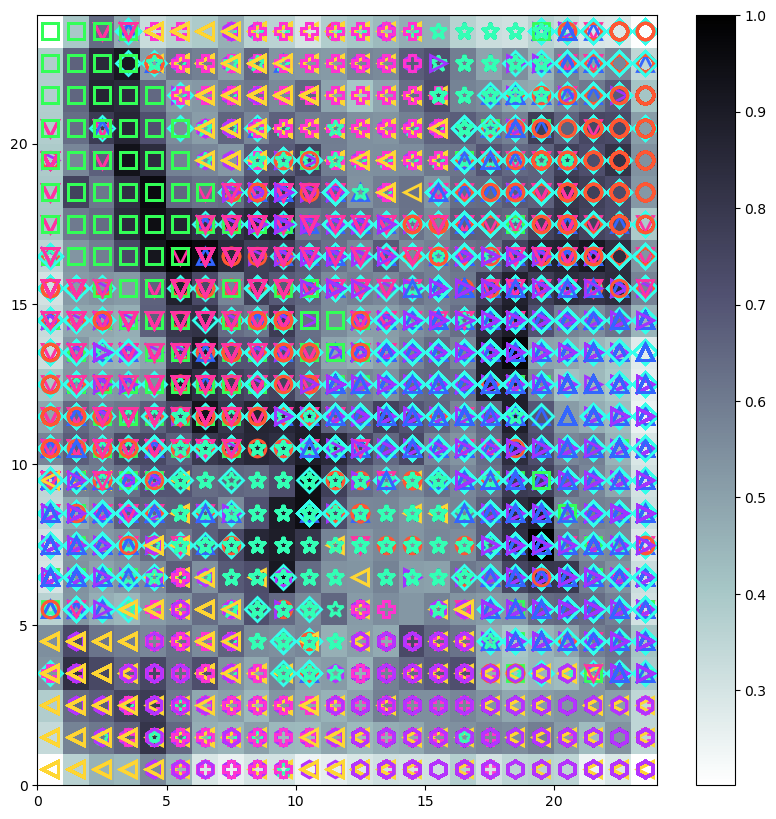

In [4]:
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in Fashion MNIST
# different colors and markers for each label
markers = ['o', 's', '^', 'v', '>', '<', 'D', 'P', '*', 'h']
colors = ['#FF5733', '#33FF57', '#3366FF', '#FF33A1', '#A133FF', '#FFD633', '#33FFEC', '#FF33D1', '#33FFB5', '#B533FF']


for cnt, xx in enumerate(all_images):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[1]+.5, w[0]+.5, markers[all_labels[cnt]], markerfacecolor='None',
             markeredgecolor=colors[all_labels[cnt]], markersize=12, markeredgewidth=2)

plt.show()

## Digits mapping

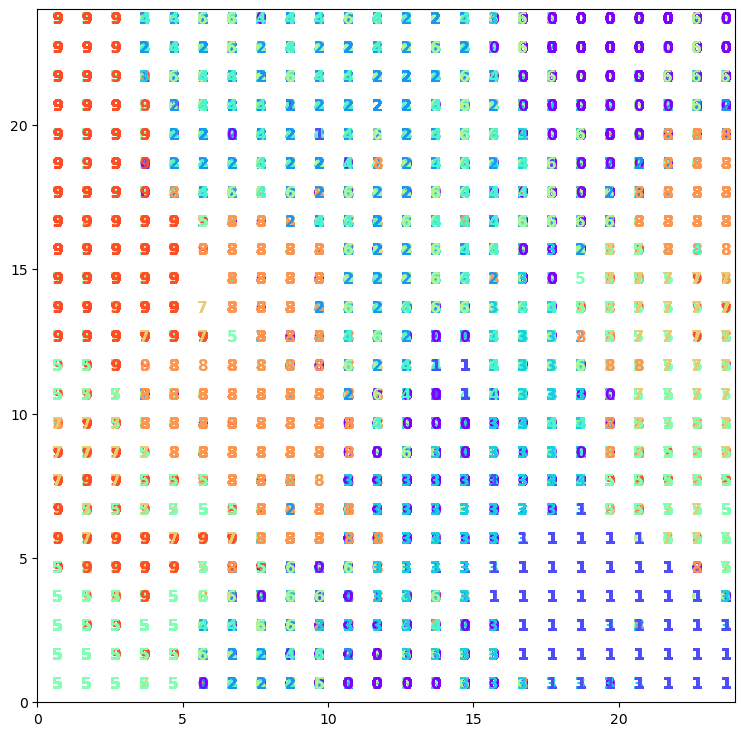

In [5]:
plt.figure(figsize=(9, 9))
wmap = {}
im = 0
for x, t in zip(all_images, all_labels):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt.text(w[0]+.5,  w[1]+.5,  str(t), color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

En ambas visualizaciones se pueden observar clúster bien definidos a excepción de algunos que estan dispersos por toda la cuadrícula. De ahí en más, los resultados son provechosos.

## Agrupamiento imágenes satelitales

In [6]:
# Establecer el ancho y altura de las imágenes después del redimensionamiento
img_width, img_height = 128, 128

# Directorio raíz donde se encuentran las carpetas de clases
root_dir = "data"

# Lista de subdirectorios (cada subdirectorio es una clase)
class_folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]

# Listas para almacenar características y etiquetas
all_features = []
all_labels = []

# Función para extraer características de una imagen
def extract_features(image):
    # Redimensionar la imagen a 128x128
    rgb_resized = resize(image, (img_height, img_width), anti_aliasing=True)

    # Convertir a escala de grises
    gray_resized = img_as_ubyte(rgb2gray(rgb_resized))

    # Histogramas de color
    nbins = 16
    rh = np.histogram(rgb_resized[:,:,0].flatten(), nbins, density=True)
    gh = np.histogram(rgb_resized[:,:,1].flatten(), nbins, density=True)
    bh = np.histogram(rgb_resized[:,:,2].flatten(), nbins, density=True)
    hist_descriptor = np.concatenate((rh[0], gh[0], bh[0]))

    # Descriptores de textura usando GLCM
    glcm = graycomatrix(gray_resized, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4])
    texture_desc = [graycoprops(glcm, 'dissimilarity')[0, 0], graycoprops(glcm, 'homogeneity')[0, 0], graycoprops(glcm, 'energy')[0, 0], graycoprops(glcm, 'correlation')[0, 0]]

    return hist_descriptor, texture_desc

# Iterar sobre cada carpeta de clase
for class_folder in class_folders:
    class_path = os.path.join(root_dir, class_folder)

    # Iterar sobre cada archivo de imagen en la carpeta de clase
    for filename in os.listdir(class_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Asegurarse de que el archivo sea una imagen
            image_path = os.path.join(class_path, filename)

            # Cargar la imagen
            rgb = io.imread(image_path)

            # Extraer características
            hist_descriptor, texture_desc = extract_features(rgb)

            # Almacenar características y etiquetas
            all_features.append(np.concatenate([hist_descriptor, texture_desc]))
            all_labels.append(class_folder)

# Convertir a matrices numpy
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Verificar las dimensiones de las matrices resultantes
print("Dimensiones de características:", all_features.shape)
print("Dimensiones de etiquetas:", all_labels.shape)

Dimensiones de características: (2016, 52)
Dimensiones de etiquetas: (2016,)


In [7]:
all_features[1]

array([5.06462411e-01, 1.14958928e+00, 5.02844822e+00, 9.44793569e+00,
       1.10376649e+01, 5.20530811e+00, 4.42149724e-01, 2.61270291e-02,
       3.41661150e-02, 2.00977147e-02, 1.00488574e-02, 2.00977147e-03,
       6.02931441e-03, 4.01954294e-03, 4.01954294e-03, 4.01954294e-03,
       2.02252091e-01, 3.22694348e-01, 5.93121301e-01, 8.47640787e-01,
       8.79455723e-01, 7.45378494e-01, 8.31733319e-01, 1.37940471e+00,
       3.34965823e+00, 1.25146322e+01, 1.53052566e+01, 2.18159559e-01,
       1.81799633e-02, 1.13624770e-02, 4.54499082e-03, 9.08998163e-03,
       1.96800823e-01, 3.86312727e-01, 7.21603019e-01, 9.42700241e-01,
       9.25692762e-01, 1.01801907e+00, 1.17837530e+00, 2.12593482e+00,
       5.68535712e+00, 1.42255410e+01, 1.23109848e+01, 4.37335163e-02,
       1.70074786e-02, 1.45778388e-02, 4.85927959e-03, 9.71855918e-03,
       4.24294970e+00, 4.22147382e-01, 9.89850734e-02, 7.67459713e-01])

In [8]:
all_labels[1]

'Agua'

In [9]:
# Normalizar las características
all_features_standard = (all_features - all_features.min()) / (all_features.max() - all_features.min())

# Codificar etiquetas
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

In [10]:
# Numéro de m y n neuronas
som_shape = (20, 20)
# Crear el mapa autootganizados 
som = MiniSom(som_shape[0], som_shape[1], all_features_standard.shape[1], sigma=3, learning_rate=.5,
              neighborhood_function='triangle', random_seed=10)
# Pesos del SOM
som.pca_weights_init(all_features_standard)

# Entrenar el SOM con las imágenes
som.train(all_features_standard, 15000, verbose=False)

## Distance Map

Agua => dígito 0, figura círculo

Bosque => dígito 1, figura cuadrado

Ciudad => dígito 2, figura triángulo hacia arriba 

Cultivo => dígito 3, figura triángulo hacia abajo

Desierto => dígito 4, figura triángulo hacia la derecha

Montaña => dígito 5, figura triángulo hacia la izquierda

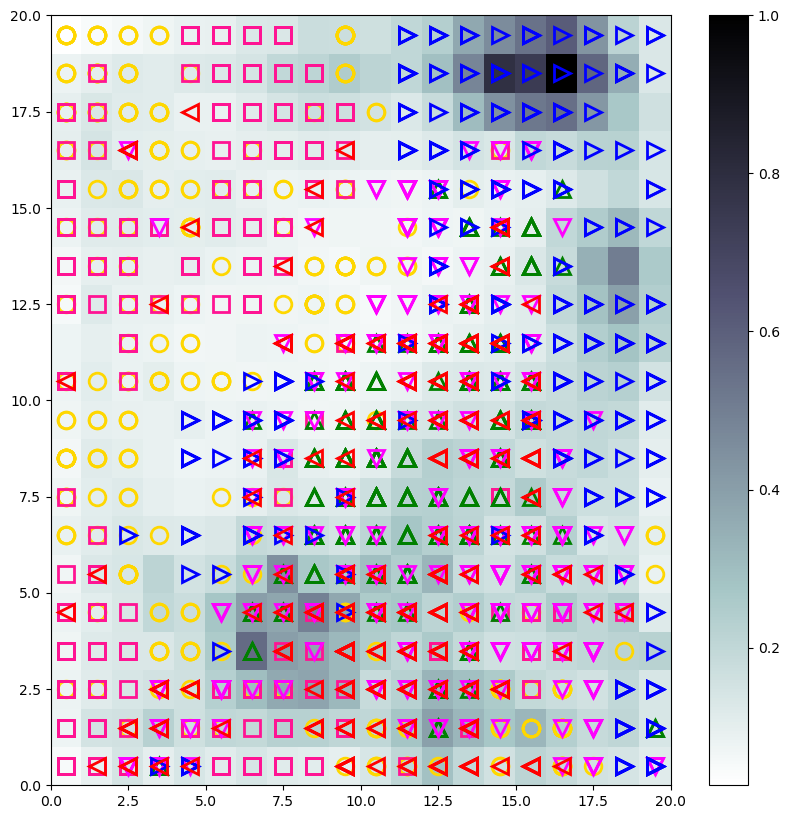

In [11]:
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in Fashion MNIST
# different colors and markers for each label
markers = ['o', 's', '^', 'v', '>', '<']
colors = ['gold','deeppink', 'green', 'magenta', 'blue', 'r']


for cnt, xx in enumerate(all_features_standard):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[1]+.5, w[0]+.5, markers[all_labels_encoded[cnt]], markerfacecolor='None',
             markeredgecolor=colors[all_labels_encoded[cnt]], markersize=12, markeredgewidth=2)

plt.show()

## Digits mapping

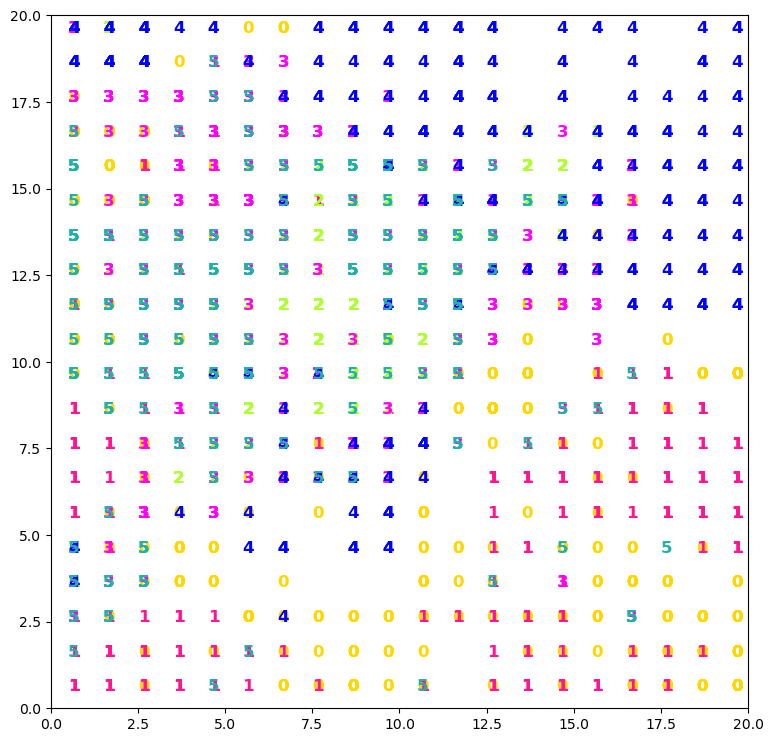

In [12]:
custom_colors = ['gold','deeppink', 'greenyellow', 'magenta', 'blue', 'lightseagreen']
plt.figure(figsize=(9, 9))
wmap = {}
im = 0
for x, t in zip(all_features_standard, all_labels_encoded):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt.text(w[0]+.5,  w[1]+.5,  str(t), color=custom_colors[t], fontdict={'weight': 'bold',  'size': 12})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

Estas visualizaciones son más sencillas de interpretar debido a que son menos clases, y como pasó en el conjunto de Fashion-MNIST la mayoría de las categorías se agrupo en clústers definidos, lo cual sustenta que los SOM son buenos agrupando conjuntos de imágenes.

# Agrupamiento de imágenes de verduras

In [ ]:
# Establecer el ancho y altura de las imágenes después del redimensionamiento
img_width, img_height = 64, 64

# Directorio raíz donde se encuentran las carpetas de clases
root_dir = "data_verduras"

# Lista de subdirectorios (cada subdirectorio es una clase)
class_folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]

# Listas para almacenar características y etiquetas
all_features = []
all_labels = []

# Función para extraer características de una imagen
def extract_features(image):
    # Redimensionar la imagen a 128x128
    rgb_resized = resize(image, (img_height, img_width), anti_aliasing=True)

    # Convertir a escala de grises
    gray_resized = img_as_ubyte(rgb2gray(rgb_resized))

    # Histogramas de color
    nbins = 8
    rh = np.histogram(rgb_resized[:,:,0].flatten(), nbins, density=True)
    gh = np.histogram(rgb_resized[:,:,1].flatten(), nbins, density=True)
    bh = np.histogram(rgb_resized[:,:,2].flatten(), nbins, density=True)
    hist_descriptor = np.concatenate((rh[0], gh[0], bh[0]))

    # Descriptores de textura usando GLCM
    glcm = graycomatrix(gray_resized, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4])
    texture_desc = [graycoprops(glcm, 'dissimilarity')[0, 0], graycoprops(glcm, 'homogeneity')[0, 0], graycoprops(glcm, 'energy')[0, 0], graycoprops(glcm, 'correlation')[0, 0]]

    return hist_descriptor, texture_desc

# Iterar sobre cada carpeta de clase
for class_folder in class_folders:
    class_path = os.path.join(root_dir, class_folder)

    # Iterar sobre cada archivo de imagen en la carpeta de clase
    for filename in os.listdir(class_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Asegurarse de que el archivo sea una imagen
            image_path = os.path.join(class_path, filename)

            # Cargar la imagen
            rgb = io.imread(image_path)

            # Extraer características
            hist_descriptor, texture_desc = extract_features(rgb)

            # Almacenar características y etiquetas
            all_features.append(np.concatenate([hist_descriptor, texture_desc]))
            all_labels.append(class_folder)

# Convertir a matrices numpy
all_features = np.array(all_features)
all_labels = np.array(all_labels)

In [30]:
# Verificar las dimensiones de las matrices resultantes
print("Dimensiones de características:", all_features.shape)
print("Dimensiones de etiquetas:", all_labels.shape)

Dimensiones de características: (2528, 28)
Dimensiones de etiquetas: (2528,)


In [18]:
all_features[1]

array([ 0.47700384,  2.41829852,  4.06007916,  0.59680945,  0.04880969,
        0.05546556,  0.49475282,  0.93625869,  0.7017579 ,  3.08305636,
        4.13101482,  0.0654974 ,  0.05146225,  0.09590691,  0.64561727,
        0.80702158,  0.51769923,  2.41592974,  4.06366062,  2.50499627,
        0.08906653,  0.31173287,  0.96581523,  0.53161587, 16.91075212,
        0.13365381,  0.02664937,  0.78494875])

In [19]:
all_labels[1]

'Cebolla'

In [20]:
# Normalizar las características
all_features_standard = (all_features - all_features.min()) / (all_features.max() - all_features.min())

# Codificar etiquetas
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

In [21]:
# Numéro de m y n neuronas
som_shape = (20, 20)
# Crear el mapa autootganizados 
som = MiniSom(som_shape[0], som_shape[1], all_features_standard.shape[1], sigma=3, learning_rate=.5,
              neighborhood_function='triangle', random_seed=10)
# Pesos del SOM
som.pca_weights_init(all_features_standard)

# Entrenar el SOM con las imágenes
som.train(all_features_standard, 15000, verbose=False)

## Distance map

Cebolla => dígito 0, figura círculo

Chayote => dígito 1, figura cuadrado

Jitomate => dígito 2, figura triángulo hacia arriba

Pepino  => dígito 3, figura triángulo hacia abajo

Zanahoria => dígito 4, figura triángulo hacia la derecha

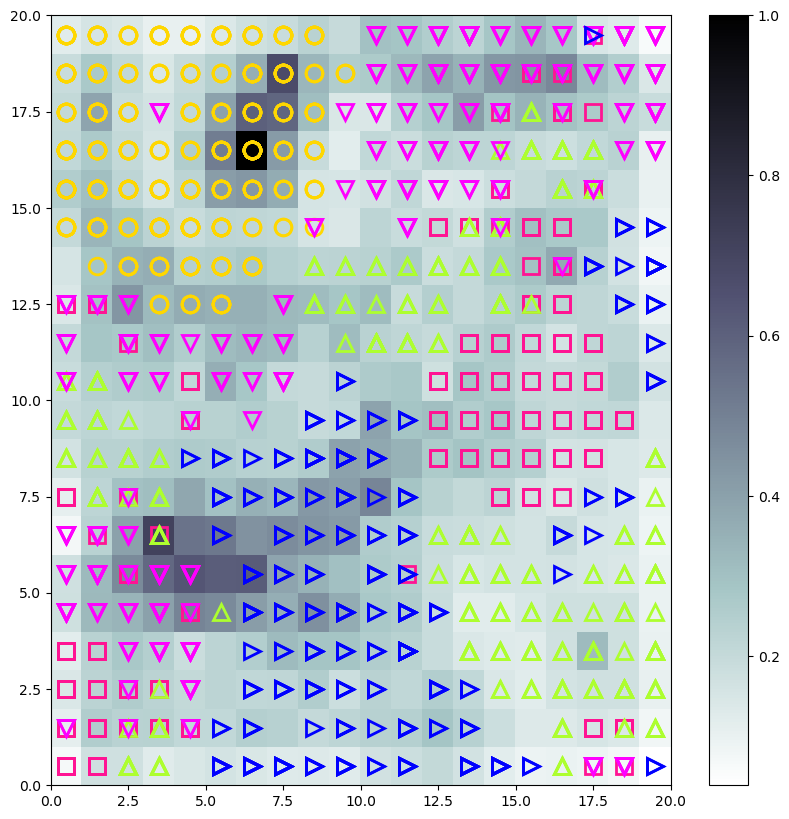

In [22]:
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in Fashion MNIST
# different colors and markers for each label
markers = ['o', 's', '^', 'v', '>']
colors = ['gold','deeppink', 'greenyellow', 'magenta', 'blue']


for cnt, xx in enumerate(all_features_standard):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[1]+.5, w[0]+.5, markers[all_labels_encoded[cnt]], markerfacecolor='None',
             markeredgecolor=colors[all_labels_encoded[cnt]], markersize=12, markeredgewidth=2)

plt.show()

## Digits map

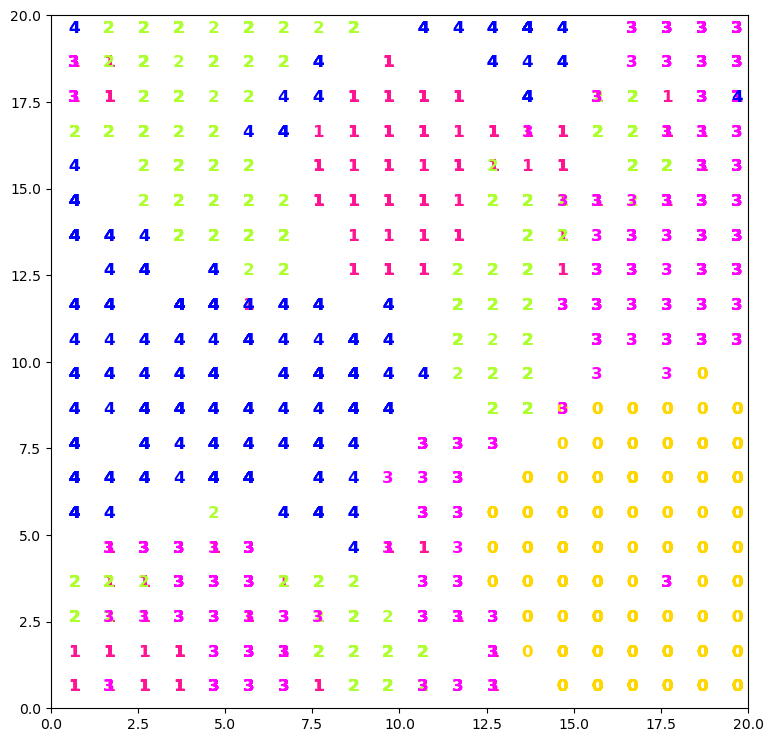

In [23]:
custom_colors = ['gold','deeppink', 'greenyellow', 'magenta', 'blue']
plt.figure(figsize=(9, 9))
wmap = {}
im = 0
for x, t in zip(all_features_standard, all_labels_encoded):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt.text(w[0]+.5,  w[1]+.5,  str(t), color=custom_colors[t], fontdict={'weight': 'bold',  'size': 12})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

# Resultados 

**¿Qué ventajas observas al utilizar mapas autoorganizado respecto a las técnicas clásicas de agrupamiento?**

Los tres modelos de mapas autoorganizados consiguieron clasificar la mayoría de las clases en agrupamientos, lo cual concuerda con las expectativas iniciales. Estos resultados indican un desempeño eficiente al organizar las variables objetivo en conjuntos coherentes. A pesar de que se nota que algunas clases no se agruparon de manera precisa y están dispersas en los mapas, es crucial destacar que estas instancias son mínimas en comparación con aquellas que están claramente definidas en clústers. Los resultados obtenidos mediante los modelos SOM exhiben una eficacia notable en la agrupación y disposición de las variables, evidenciando la capacidad de esta técnica en el análisis y la clasificación de imágenes.

Los mapas autoorganizados presentan diversas ventajas en comparación con las técnicas convencionales de agrupamiento. Una de sus características fundamentales es la preservación topológica, la cual mantiene las relaciones espaciales entre los datos en el mapa generado. Asimismo, los SOM posibilitan la reducción de dimensionalidad, permitiendo la visualización de estructuras en conjuntos de datos complejos. Su flexibilidad y habilidad para adaptarse a datos ruidosos y no lineales los convierten en herramientas útiles en varias aplicaciones, especialmente en el agrupamiento de datos no estructurados, como es el caso de las imágenes.